# Entretien technique
Alexis Mortelier

28/10/2020
# Le sujet
Pour cet entretien j'ai dû résoudre un challenge Kaggle (https://www.kaggle.com/c/springleaf-marketing-response/overview) Ce challenge me demande à l'aide des données brutes et anonymisées de la société Springleaf de déterminer quel type de client est le plus susceptible de répondre et d'être un bon candidat pour leurs services. Je dois donc mettre en place une solution permettant de prédire quels clients répondront favorablement à une offre de publipostage.

# Les enjeux
Une campagne de publipostage coute de l'argent et qui n'a jamais mis un prospectus à la poubelle sans l'avoir lu. Le principe est d'éviter ça, il est de déterminer les personnes qui n'y seront pas sensibles afin d'éviter de perdre de l'argent en ciblant les mauvais clients.

In [1]:
from xgboost import XGBClassifier
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn import svm

# Les données
Un ensemble de données de grande dimension contenant des informations client anonymisées est fourni. Chaque ligne correspond à un client. La variable cible ("target") est binaire et indique si le client est sensible au publipostage : 1 Oui 0 Non. Je dois donc prédire la variable cible pour l'ensemble des données du fichier test. Les données ont été anonymisées je ne sais donc pas à quoi correspond une variable parmis les 1934 par client. Il existe aussi des valeurs manquantes sur certains champs.

Je lis donc les données et affiche un echantillon afin de prendre connaissance de celle-ci.

In [2]:
train = pd.read_csv("../data/train.csv", sep=',', low_memory=False)
test = pd.read_csv("../data/test.csv", sep=',', low_memory=False)


In [3]:
test.head()

,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,...,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934
0,1,R,360,25,2251,B,2.0,2.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS
1,3,R,74,192,3274,C,2.0,3.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS
2,6,R,21,36,3500,C,1.0,1.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS
3,9,R,8,2,1500,B,0.0,0.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS
4,10,H,91,39,84500,C,8.0,3.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS


# Preparation des données
Ma formation ainsi que les articles lû m'indique qu'un classifieur est l'outil le plus adapté à ce genre de problème.Je prépare donc mes données en conséquences, une variable X contiendra l'ensemble des variables d'informations, et une variable y contiendra la valeure cible.

In [3]:
X = train.drop(['ID','target'],axis=1)
y = train['target']
X_test = test.drop(['ID'],axis=1)

Un classifieur a besoin de données qualitatives afin d'être entrainé, il ne comprend pas les données qualitatives. Pour se faire je vais donc préparer mes données afin de transformer mes données qualitatives en données quantitatives. Je ne touche pas aux donnés déjà quantitatifs. Suite à cela je remplacerais les valeurs manquantes par "-1" qui est un entier qui n'apparaît pas comme valeurs de nos variables.

In [4]:
def prepareData(df):
    objColumnNames = df.select_dtypes(include = "object").columns
    le = LabelEncoder()
    for varName in objColumnNames:
        df[varName] = le.fit_transform(df[varName].astype("str")).astype("int64")

prepareData(X)
prepareData(X_test)
X.fillna(-1)
X_test.fillna(-1)

,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,...,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934
0,2,360,25,2251,0,2.0,2.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
1,2,74,192,3274,1,2.0,3.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
2,2,21,36,3500,1,1.0,1.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
3,2,8,2,1500,0,0.0,0.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
4,0,91,39,84500,1,8.0,3.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145227,2,84,0,4717,0,0.0,0.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,0
145228,2,29,15,1350,1,2.0,1.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
145229,0,194,360,2481,0,0.0,0.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,0
145230,0,33,40,4695,0,1.0,1.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2


Je vérifie que les données ont bien été modifié

In [6]:
X.head()

,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,...,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934
0,0,224,0,4300,1,0.0,0.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
1,0,7,53,4448,0,1.0,0.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
2,0,116,3,3464,1,0.0,0.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,2
3,0,240,300,3200,1,0.0,0.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,4
4,2,72,261,2000,2,0.0,0.0,0,0,0,...,0,98,98,998,999999998,998,998,9998,9998,0


Je vérifie le type dès mes données et ce sont bien des entiers et donc des variables quantitatives

In [7]:
X.dtypes

VAR_0001    int64
VAR_0002    int64
VAR_0003    int64
VAR_0004    int64
VAR_0005    int64
            ...  
VAR_1930    int64
VAR_1931    int64
VAR_1932    int64
VAR_1933    int64
VAR_1934    int64
Length: 1932, dtype: object

n'ayant pas de données cible dans le fichier de données test, je me vois donc obliger à découper mon fichier d'entrainement. 80% des données seront préparés pour l'entrainement du réseau et les 20% restants serviront à sa validation.

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Le classifieur
Après différentes recherches sur le choix de mon classifieur j'ai décidé d'utiliser un algorithme de Boosting de gradient il s'agit d'un algorithme d'arbe de décision.
Les arbres de décision boostés sont un ensemble de petits arbres où chaque arbre évalue les données d’entrée, puis passe le score à l’arbre suivant pour produire un meilleur score, et ainsi de suite. Chaque arbre de l’ensemble représente une amélioration par rapport à l’arbre précédent.
Son principe est de combiner les résultats d'un ensemble de modèles plus simple et plus faible afin de fournir une meilleure prédiction. Cela fait quelques années qu'il s'agit de l'algorithme le plus rapide et le plus précis pour résoudre des cas de classification binaire d'après les articles que j'ai lus.

In [6]:
dtrain = xgb.DMatrix(X_train, y_train)

params = {'eval_metric': 'auc', 
         'objective': 'binary:logistic'
        }
num_boost_round = 999

In [27]:
dvalid = xgb.DMatrix(X_valid, y_valid)

In [ ]:
clf = xgb.train(params, dtrain, num_boost_round, evals=[(dvalid, "Test")], early_stopping_rounds=10)
y_pred = clf.predict(dvalid)
prediction = y_pred.round()

# Verifions notre classifieur
Une fois le classifieur entrainé et testé sur les données de validation, il faut vérifier son efficacité. Différentes méthodes sont possibles. On peut utiliser une matrice de confusion afin d'avoir une idée plus précise sur notre classifieur. On peut donc voir les vrais/Faux positifs ainsi que les vrais/Faux négatifs.

## Scores
Il existe aussi différentes metrics pour mesurer l'efficacité, comme l'accuracy, la précision, le recall, et le F1 score.

l'accuracy est le taux de bonne classification ou l’exactitude. -> taux de vrai positif + taux de vrai.

la précision donne le pourcentage de bonne réponse. -> taux de vrai positif /(taux vrai positif + taux de faux positif).

le recall, permet de calculer la proportion de résultats positifs réels identifiés correctement -> le taux de vrai positif /(taux de vrai positif + taux de faux négatifs).

Le score F1 quant à lui est une manière de combiner la précision et le rappel du modèle, et il est défini comme la moyenne harmonique de la précision et du rappel du modèle. Plus la précision est proche de 1 meilleure est la qualité. Un score F1 atteint sa meilleure valeur à 1 et sa pire à 0. Il indique le degré de précision de notre classifieur.

L'accuracy et la précision sont deux différents aspects liés à l'obtention d'une mesure correcte. L'accuracy est liée à la proximité de la valeur réelle d'une mesure particulière (ou d'un ensemble de mesures). La précision est le degré de résolution d'une différence et la répétabilité d'une mesure.

In [29]:
def show_score(pred):
    conf_mat = confusion_matrix(y_valid, pred)
    #0,0 -> TrueNegative
    #1,0 -> FalseNegative
    #1,1 -> TruePositive
    #0,1 -> FalsePositive
    print("Matrice de confusion:\n", conf_mat)
    print(conf_mat[0,0],"-> TrueNegative")
    print(conf_mat[1,0],"-> FalseNegative")
    print(conf_mat[1,1],"-> TruePositive")
    print(conf_mat[0,1],"-> FalsePositive")

    print("Accuracy score : ", accuracy_score(y_valid, pred))
    print("Precision score : ", average_precision_score(y_valid, pred))
    print("recall score : ", recall_score(y_valid, pred))
    print("F1 score : ", f1_score(y_valid, pred))

In [14]:
show_score(prediction)

Matrice de confusion:
 [[21061  1145]
 [ 4972  1869]]
21061 -> TrueNegative
4972 -> FalseNegative
1869 -> TruePositive
1145 -> FalsePositive
Accuracy score :  0.7894102661204255
Precision score :  0.34058738403761346
recall score :  0.2732056716854261
F1 score :  0.37929984779299847


## Courbe ROC
L'aire sous la courbe mesure la zone sous la courbe créée en balayant le taux réel positif par rapport au taux de faux positifs.Plus la précision est proche de 1 meilleure est la qualité.Plus la précision est proche de 1, meilleure est la qualité. L'aire sous la courbe doit être au-dessus de 0,5. Si l'air vaut 0,5 cela revient au hasard si elle est comprise entre 0,7 à 0,8 c'est considéré comme acceptable, 0,8 à 0,9 c'est considéré comme excellent et plus de 0,9 c'est considéré comme exceptionnel.



In [30]:
def show_roc_curve(pred):
    fpr,tpr,thresholds = roc_curve(y_valid,pred)
    roc_auc = auc(fpr,tpr)
    plt.clf()
    plt.plot(fpr, tpr, label='Courbe ROC (aire = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taux de Faux Positif')
    plt.ylabel('Taux de Vrai Positif')
    plt.legend(loc="lower right")
    plt.show()

    print('ROC auc (roc_curve et auc)',roc_auc)
    print('ROC auc (  roc_auc_score )',roc_auc_score(y_valid, pred))

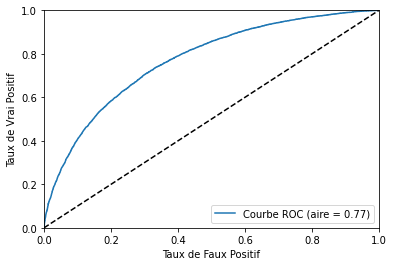

ROC auc (roc_curve et auc) 0.77136262512125
ROC auc (  roc_auc_score ) 0.77136262512125


In [15]:
show_roc_curve(y_pred)

# Premiere analyse
Si on se fie à la courbe ROC on peut se dire que notre classifier est bon. En effet, on estime qu'un classifier est bon à partir d'un score de 0.7. Or si on s'interesse de plus pret à la matrice de confusion et aux scores tels que le rappel et la précision, on se rend compte qu'il n'est pas si bon que ça. En effet, dans l'idéal on veut que notre rappel et notre précision soient à peu près les mêmes et les plus proche possible de 1. Le F1 score va permettre cette mesure. Ici on a un F1 score faible qui nous indique que notre classifieur peut etre amélioré.

De mon point de vue il y a une grosse disparité sur nos cibles dans nos données d'entrainements.On va donc séparer notre donnée d'entrainement en deux data frame. Un qui contient les clients que l'on veut cibler, et un autre contenant les clients qu'on ne veut pas cibler. Ce procédé va permettre de vérifier ma théorie.

In [8]:
#On remet à notre X_train la cible avec comme identifiant de column "y"
X_train['y']=y_train
#On separe notre X_train en deux sous X_train, un pour ceux qui seront des cibles, et un ou ils ne seront pas des cibles
X_train_1,X_train_0=X_train[X_train.y==1],X_train[X_train.y==0]
#reinitialise les index des X_train et remet celui par défault de pandas
X_train_1=X_train_1.reset_index(drop=True)
X_train_0=X_train_0.reset_index(drop=True)

<ipython-input-8-c7c5f7a214b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['y']=y_train


In [7]:
print("X_train_1 :",X_train_1.shape)
print("X_train_0 :",X_train_0.shape)
print("Difference de : ",X_train_0.shape[0]/X_train_1.shape[0])
# Il y a un probleme de taille entre le nombre de personne qui sont une cible et ceux qui ne le sont pas.

X_train_1 : (26932, 1933)
X_train_0 : (89252, 1933)
Difference de :  3.313975939402941


 Et en effet, il y a dans nos données d'entrainements environ 3.3 fois plus de client non susceptible aux offres qu'aux clients susceptibles d'être intéresser aux offres. Première idée -> on va réduire le nombre de données appartenant au groupe de clients qu'on ne veut pas cibler à celui du nombre de clients que l'on veut cibler. De ce fait la distribution de notre cible ne sera plus disparate.
 
 On va donc recréer un dataset comprenant autant de clients cible que  de client non cible puis on va le mélanger

In [9]:
X_train_0_new = X_train_0[:X_train_1.shape[0]]
X_train_new = X_train_1.append(X_train_0_new)
X_train_new = shuffle(X_train_new)
X_train_new

,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,...,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,y
25363,2,13,140,1600,2,2.0,1.0,0,0,0,...,98,98,998,999999998,998,998,9998,9998,3,1
25444,2,1,7,3000,2,1.0,2.0,0,0,0,...,98,98,998,999999998,998,998,9998,9998,2,1
2357,2,276,65,1736,0,0.0,0.0,0,0,0,...,98,98,998,999999998,998,998,9998,9998,0,0
20216,0,999,999,1800,0,0.0,0.0,0,0,0,...,0,0,0,27,1,1,9996,219,2,1
17529,0,159,156,4200,1,1.0,1.0,0,0,0,...,98,98,998,999999998,998,998,9998,9998,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25126,2,38,3,1421,0,1.0,1.0,0,0,0,...,98,98,998,999999998,998,998,9998,9998,2,1
4301,0,65,65,4600,1,0.0,0.0,0,0,0,...,98,98,998,999999998,998,998,9998,9998,0,1
24927,2,76,0,3500,1,1.0,1.0,0,0,0,...,98,98,998,999999998,998,998,9998,9998,2,0
11351,2,73,18,1367,2,0.0,0.0,0,0,0,...,98,98,998,999999998,998,998,9998,9998,0,1


In [10]:
y_train_new = X_train_new.iloc[:,-1]
X_train_new = X_train_new.drop(X_train_new.columns[-1],axis=1)
dtrain_new = xgb.DMatrix(X_train_new, y_train_new)

On va donc réentrainer notre classifieur sur notre nouveau dataset ayant une bonne distribution

In [17]:
clf = xgb.train(params, dtrain_new, num_boost_round, evals=[(dvalid, "Test")], early_stopping_rounds=10)
y_pred = clf.predict(dvalid)

# Scores et courbe ROC
Nous allons regarder la validité de notre classifieur à l'aide des méthodes précédentes, nos scores ainsi que notre courbe ROC

Matrice de confusion:
 [[15745  6461]
 [ 2107  4734]]
15745 -> TrueNegative
2107 -> FalseNegative
4734 -> TruePositive
6461 -> FalsePositive
Accuracy score :  0.7050297793231659
Precision score :  0.3651635494755696
recall score :  0.6920040929688642
F1 score :  0.5249500998003992


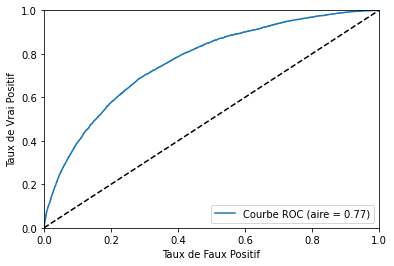

ROC auc (roc_curve et auc) 0.766933858208233
ROC auc (  roc_auc_score ) 0.766933858208233


In [18]:
prediction = y_pred.round()
show_score(prediction)
show_roc_curve(y_pred)

# Deuxieme analyse
C'est un peu mieux ! on a réussi à grandement augmenter nos scores et légèrement notre roc auc score en rendant plus homogène notre distribution de données. Mais, on a perdu une quantité énorme de données et ce serait bête de ne pas les utiliser. De plus avec un recall score haut et un score de précision faible notre classifieur nous fournira en guise de cible de nombreux faux positifs en plus de ceux pertinents. Ce qui explique ce score F1 moyen.

Deuxième idée -> Nous allons construire X0, X1, X2, chaque X va contenir tous les 1 de X_Train, puis on va diviser le X_Train_0 en 3 parties et on injecte chaque partie dans un X différent. --> On va ainsi construire 3 échantillons de X qui sont complètement balancés (contiennent autant de 1 que de 0) mais on aura tous les 0 contrairement à la méthode précédente. On choisis de construire 3 dataframe du fait qu'une des deux classes est 3 fois plus representé que l'autre.

Le code suivant va donc nous constuire une liste qui contient 3 DataFrames (X0,X1 et X2).

In [11]:
# Cette fonction permet de construire un DataFrame Xnew qui contiendra autant de 1 que de 0 de notre X_train

def merge_2DF(Xtrain1,Xtrain0):
    Xnew=Xtrain1.append(Xtrain0[0:len(Xtrain1)])
    return Xnew

results_train=[]
for i in range(3):
    results_train.append(merge_2DF(X_train_1,X_train_0[i*X_train_1.shape[0]:(i+1)*X_train_1.shape[0]]))

In [12]:
X0 = results_train[0].drop(results_train[0].columns[-1],axis=1)
Y0 = results_train[0].iloc[:,-1]

X1 = results_train[1].drop(results_train[1].columns[-1],axis=1)
Y1 = results_train[1].iloc[:,-1]

X2 = results_train[2].drop(results_train[2].columns[-1],axis=1)
Y2 = results_train[2].iloc[:,-1]

In [21]:
print("X0 shape : ", X0.shape)
print("Y0 shape : ", Y0.shape)

print("X1 shape : ", X1.shape)
print("Y1 shape : ", Y1.shape)

print("X2 shape : ", X2.shape)
print("Y2 shape : ", Y2.shape)

print("Somme des 3 tailles : ", X0.shape[0]+X1.shape[0]+X2.shape[0])
print("Taille du X_train : ", X_train_0.shape[0]+X_train_1.shape[0])

X0 shape :  (53864, 1932)
Y0 shape :  (53864,)
X1 shape :  (53864, 1932)
Y1 shape :  (53864,)
X2 shape :  (53864, 1932)
Y2 shape :  (53864,)
Somme des 3 tailles :  161592
Taille du X_train :  116184


Comme nous pouvons le voir, nous perdons beaucoup moins de données !
Nous allons pouvoir entrainer nos trois classifieurs sur ces trois nouveaux jeux de données.

In [24]:
d0 = xgb.DMatrix(X0, Y0)
d1 = xgb.DMatrix(X1, Y1)
d2 = xgb.DMatrix(X2, Y2)

In [10]:
clf0 = xgb.train(params, d0, num_boost_round, evals=[(dvalid, "Test")], early_stopping_rounds=10)
clf1 = xgb.train(params, d1, num_boost_round, evals=[(dvalid, "Test")], early_stopping_rounds=10)
clf2 = xgb.train(params, d2, num_boost_round, evals=[(dvalid, "Test")], early_stopping_rounds=10)

In [16]:
y_pred0 = clf0.predict(dvalid)
y_pred1 = clf1.predict(dvalid)
y_pred2 = clf2.predict(dvalid)

# Un systeme de vote
Nous allons donc effectuer une prédiction à l'aide de nos trois classifieurs. Une fois que chacun d'eux aura retourné ses predictions nous faisons une moyenne des trois afin d'obtenir la prediction totale.

In [17]:
y_pred=np.mean([y_pred0,y_pred1,y_pred2], axis=0)

# Scores et courbe ROC

Matrice de confusion:
 [[15832  6374]
 [ 2043  4798]]
15832 -> TrueNegative
2043 -> FalseNegative
4798 -> TruePositive
6374 -> FalsePositive
Accuracy score :  0.7102282507659999
Precision score :  0.37154469065407936
recall score :  0.7013594503727525
F1 score :  0.5327263642924555


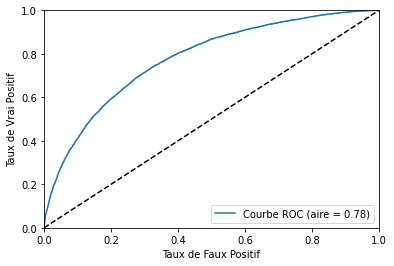

ROC auc (roc_curve et auc) 0.7771872893465702
ROC auc (  roc_auc_score ) 0.7771872893465702


In [18]:
prediction = y_pred.round()
show_score(prediction)
show_roc_curve(y_pred)

# Troisieme Analyse
On peut voir qu'il y a une légère amélioration sur l'ensemble des Scores ainsi que sur la courbe ROC.Globalement on peut voir qu'il classe bien mieux les négatifs que les positifs. Ce qui pour notre problème est une bonne chose, cela nous évitera de démarcher des clients pas sensibles à l'offre de publipostage.

# Amelioration possible : GridSearchCrossValidation
Pour optimiser les hypers-parametres de notre classifieur et évaluer la capacité de généralisation de notre classifieur.

Et c'est ce que nous allons faire. Maintenant que l'on a determiner la bonne méthode de notre classifieur il ne nous reste plus qu'a trouver les hypers parametres adèquat pour ce même classifieur sur notre jeu de données et afin d'y parvenir le gridsearch en cross validation est l'une des techniques. Afin d'éviter les problemes de memoire je vais effectuer mon grid search sur un sous ensemble de mon véritable jeu de données. Une fois cela fait nous n'aurons plus qu'a réentrainer nos 3 classifieurs avec ces parametres et effectuer un vote sur nos données de sortie.

In [18]:
gridsearch_params = [
    (max_depth, min_child_weight, subsample, colsample)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

max_auc = 0
best_params = None
for max_depth, min_child_weight, subsample, colsample in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}, subsample={}, colsample={}".format(
        max_depth,
        min_child_weight,
        subsample,
        colsample))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    cv_results = xgb.cv(
        params,
        dtrain_new,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tauc {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth, min_child_weight, subsample, colsample)
        
print("Best params: {}, {}, {}, {},  auc: {}".format(best_params[0], best_params[1], best_params[2], best_params[3], max_auc))


CV with max_depth=9, min_child_weight=5, subsample=0.7, colsample=0.7
	auc 0.6583004 for 27 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.7, colsample=0.8
	auc 0.6658514 for 11 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.7, colsample=0.9
	auc 0.6616816 for 53 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.7, colsample=1.0
	auc 0.649444 for 31 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.8, colsample=0.7
	auc 0.6604793999999999 for 11 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.8, colsample=0.8
	auc 0.6633574 for 32 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.8, colsample=0.9
	auc 0.6645717999999999 for 11 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.8, colsample=1.0
	auc 0.6663228 for 22 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.9, colsample=0.7
	auc 0.6783536 for 75 rounds
CV with max_depth=9, min_child_weight=5, subsample=0.9, colsample=0.8
	auc 0.664293 for 23 r

	auc 0.6651543999999999 for 14 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.7, colsample=0.8
	auc 0.6602154 for 13 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.7, colsample=0.9
	auc 0.6611148 for 14 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.7, colsample=1.0
	auc 0.6654975999999999 for 15 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.8, colsample=0.7
	auc 0.6672054 for 32 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.8, colsample=0.8
	auc 0.6724452000000001 for 26 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.8, colsample=0.9
	auc 0.6664152000000001 for 16 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.8, colsample=1.0
	auc 0.6739262 for 14 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.9, colsample=0.7
	auc 0.6786068000000001 for 80 rounds
CV with max_depth=10, min_child_weight=7, subsample=0.9, colsample=0.8
	auc 0.6742836000000001 for 65 rounds
CV with max_depth

In [21]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]
params['subsample'] = best_params[2]
params['colsample_bytree'] = best_params[3]

In [22]:
params

{'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'max_depth': 9,
 'min_child_weight': 6,
 'subsample': 0.9,
 'colsample_bytree': 0.7}

In [28]:
clf0 = xgb.train(params, d0, num_boost_round, evals=[(dvalid, "Test")], early_stopping_rounds=10)
clf1 = xgb.train(params, d1, num_boost_round, evals=[(dvalid, "Test")], early_stopping_rounds=10)
clf2 = xgb.train(params, d2, num_boost_round, evals=[(dvalid, "Test")], early_stopping_rounds=10)

[0]	Test-auc:0.70239
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.72345
[2]	Test-auc:0.73350
[3]	Test-auc:0.73761
[4]	Test-auc:0.74134
[5]	Test-auc:0.74632
[6]	Test-auc:0.74879
[7]	Test-auc:0.75059
[8]	Test-auc:0.75195
[9]	Test-auc:0.75356
[10]	Test-auc:0.75355
[11]	Test-auc:0.75465
[12]	Test-auc:0.75564
[13]	Test-auc:0.75511
[14]	Test-auc:0.75511
[15]	Test-auc:0.75543
[16]	Test-auc:0.75541
[17]	Test-auc:0.75545
[18]	Test-auc:0.75572
[19]	Test-auc:0.75734
[20]	Test-auc:0.75724
[21]	Test-auc:0.75733
[22]	Test-auc:0.75789
[23]	Test-auc:0.75780
[24]	Test-auc:0.75786
[25]	Test-auc:0.75798
[26]	Test-auc:0.75805
[27]	Test-auc:0.75786
[28]	Test-auc:0.75833
[29]	Test-auc:0.75842
[30]	Test-auc:0.75839
[31]	Test-auc:0.75824
[32]	Test-auc:0.75792
[33]	Test-auc:0.75778
[34]	Test-auc:0.75767
[35]	Test-auc:0.75765
[36]	Test-auc:0.75761
[37]	Test-auc:0.75786
[38]	Test-auc:0.75809
[39]	Test-auc:0.75819
Stopping. Best iteration:
[29]	Test-auc:0.75842

[0]	Test-auc:0.69866
Will

Matrice de confusion:
 [[15694  6512]
 [ 1982  4859]]
15694 -> TrueNegative
1982 -> FalseNegative
4859 -> TruePositive
6512 -> FalsePositive
Accuracy score :  0.7075773745997865
Precision score :  0.3717460185758887
recall score :  0.7102762753983336
F1 score :  0.5336042169997803


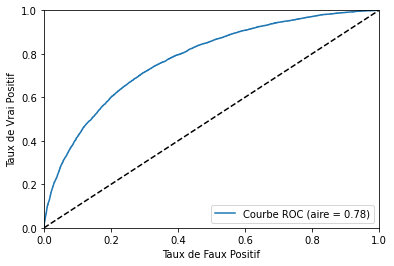

ROC auc (roc_curve et auc) 0.7774893769221008
ROC auc (  roc_auc_score ) 0.7774893769221008


In [31]:
y_pred0 = clf0.predict(dvalid)
y_pred1 = clf1.predict(dvalid)
y_pred2 = clf2.predict(dvalid)
y_pred=np.mean([y_pred0,y_pred1,y_pred2], axis=0)
prediction = y_pred.round()
show_score(prediction)
show_roc_curve(y_pred)

# Analyse
On observe une legere amelioration, on peut donc dire que ce procédé est utile si on a du temps à perdre pour un leger gain de performance.

# Ameliorations : Enlever les variables avec trop de NA pour supprimer le bruit ou garder les n variables les plus importantes

# On sauvegarde donc notre modéle finale

In [34]:
clf0.save_model('model/clf0.model')
clf1.save_model('model/clf1.model')
clf2.save_model('model/clf2.model')

# Il ne nous reste plus qu'a faire la prediction sur le fichier test fournie

In [9]:
dtest = xgb.DMatrix(X_test)
test0 = xgb.Booster()
test0.load_model('model/clf0.model')
test1 = xgb.Booster()
test1.load_model('model/clf1.model')
test2 = xgb.Booster()
test2.load_model('model/clf2.model')

y_pred0 = test0.predict(dtest)
y_pred1 = test1.predict(dtest)
y_pred2 = test2.predict(dtest)
y_pred=np.mean([y_pred0,y_pred1,y_pred2], axis=0)

# On sauvegarde la prediction dans un fichier csv

In [11]:
results_df = pd.DataFrame(data={'ID':test['ID'], 'target':y_pred})
results_df.to_csv('../data/sample_submission.csv', index=False)